In [1]:
import seaborn as sn
from imblearn.over_sampling import SMOTE 
from imblearn.combine import SMOTETomek
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, precision_score, precision_recall_curve, average_precision_score, classification_report
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from torch.utils.data import Dataset, DataLoader, random_split
from torch import Tensor
from torch.nn import Linear, ReLU, Sigmoid, Module, BCELoss, BCEWithLogitsLoss
from torch.optim import Adam
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from pandas import DataFrame
import xlsxwriter
import time

seed_value = 7
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)
import numpy as np
np.random.seed(seed_value)
import torch
torch.manual_seed(seed_value)

In [2]:
Training_Data = pd.ExcelFile("Training Data.xlsx") #Training Data already pre-scaled to the IBIS Data set
Label_Data = pd.ExcelFile("Labels.xlsx") #Labels
data = Training_Data.parse(Training_Data.sheet_names[1])
label_data = Label_Data.parse(Label_Data.sheet_names[1])
data_features = data.loc[:, data.columns]
data_features = data_features.drop(['ROI','MATCH DEMOS','INDEX SEX','MATCH BASC2','INDEX GA', 'HYP', 'INDEX MEDU', 'MATCH DEMOS OLD', 'INDEX AGE'], axis=1)
data_features = data_features.dropna()
data_features = data_features.drop(['ATP'], axis=1)
labels = label_data.loc[:, label_data.columns]
labels = labels.drop(['ROI','MATCH BASC2', 'INDEX ATP', 'INDEX HYP', 'HYP'], axis=1)
labels = labels.dropna()
print(data_features.shape)
print(labels.shape)

(127, 300)
(127, 1)


In [3]:
skf = StratifiedKFold(n_splits=8)
skf.get_n_splits(data_features, labels)
print(skf)

training_indices_X = []
testing_indices_X = []
training_indices_Y = []
testing_indices_Y = []

for train_index, test_index in skf.split(data_features, labels):
  
    X_train, X_test = data_features.iloc[train_index], data_features.iloc[test_index]
    Y_train, Y_test = labels.iloc[train_index], labels.iloc[test_index]
   
    sm = SMOTE(sampling_strategy = 'minority', random_state = seed_value, k_neighbors=2) 
    X_train_res, Y_train_res = sm.fit_sample(X_train, Y_train) #Only smote the training set.
    print(X_train_res.shape)
    training_indices_X.append(X_train_res)
    testing_indices_X.append(X_test)
    training_indices_Y.append(Y_train_res)
    testing_indices_Y.append(Y_test)


StratifiedKFold(n_splits=8, random_state=None, shuffle=False)
(190, 300)
(190, 300)
(190, 300)
(190, 300)
(190, 300)
(192, 300)
(192, 300)
(192, 300)


In [4]:
training_indices_X[0].head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,SEX,Gestational Age,Maternal Education MEDU,Age at MRI 2
0,-0.293787,0.003139,0.025914,0.167209,-0.327508,-0.292465,-0.348738,-0.218615,-0.078855,-0.086240,...,0.334543,0.743217,0.229896,0.115003,0.613862,0.419573,0.0,0.916667,14.0,1.161644
1,-0.134314,0.048638,0.157068,-0.118706,-0.098239,-0.109438,0.014594,-0.336313,0.074765,0.071769,...,0.216634,0.271318,0.347661,0.134042,0.413723,0.255445,1.0,0.750000,9.0,1.024658
2,-0.163454,0.075192,-0.022291,-0.138708,-0.049811,0.057390,-0.165016,-0.404240,-0.087664,-0.077308,...,0.226022,0.419697,0.351481,0.487143,0.186957,0.223046,1.0,0.833333,10.0,0.972603
3,-0.173784,-0.086895,-0.044482,-0.140339,-0.132705,-0.341187,-0.244494,-0.364035,-0.062480,-0.095222,...,0.109657,0.128430,0.526648,0.083436,0.535189,0.444251,0.0,0.500000,14.0,1.008219
4,-0.384659,0.110031,0.069220,-0.116755,-0.405043,-0.095715,0.008814,-0.253376,-0.013787,0.106184,...,0.144029,0.241537,0.264994,0.284063,0.312178,0.391243,0.0,0.666667,19.0,1.015068


In [5]:
#training_indices_X[0] #8 Folds so 0 -> 7 Data type is a DataFrame currently.
training_fold_X_0 = training_indices_X[0].to_numpy()
training_fold_X_1 = training_indices_X[1].to_numpy()
training_fold_X_2 = training_indices_X[2].to_numpy()
training_fold_X_3 = training_indices_X[3].to_numpy()
training_fold_X_4 = training_indices_X[4].to_numpy()
training_fold_X_5 = training_indices_X[5].to_numpy()
training_fold_X_6 = training_indices_X[6].to_numpy()
training_fold_X_7 = training_indices_X[7].to_numpy()

training_fold_Y_0 = training_indices_Y[0].to_numpy()
training_fold_Y_1 = training_indices_Y[1].to_numpy()
training_fold_Y_2 = training_indices_Y[2].to_numpy()
training_fold_Y_3 = training_indices_Y[3].to_numpy()
training_fold_Y_4 = training_indices_Y[4].to_numpy()
training_fold_Y_5 = training_indices_Y[5].to_numpy()
training_fold_Y_6 = training_indices_Y[6].to_numpy()
training_fold_Y_7 = training_indices_Y[7].to_numpy()

testing_fold_X_0 = testing_indices_X[0].to_numpy()
testing_fold_X_1 = testing_indices_X[1].to_numpy()
testing_fold_X_2 = testing_indices_X[2].to_numpy()
testing_fold_X_3 = testing_indices_X[3].to_numpy()
testing_fold_X_4 = testing_indices_X[4].to_numpy()
testing_fold_X_5 = testing_indices_X[5].to_numpy()
testing_fold_X_6 = testing_indices_X[6].to_numpy()
testing_fold_X_7 = testing_indices_X[7].to_numpy()

testing_fold_Y_0 = testing_indices_Y[0].to_numpy()
testing_fold_Y_1 = testing_indices_Y[1].to_numpy()
testing_fold_Y_2 = testing_indices_Y[2].to_numpy()
testing_fold_Y_3 = testing_indices_Y[3].to_numpy()
testing_fold_Y_4 = testing_indices_Y[4].to_numpy()
testing_fold_Y_5 = testing_indices_Y[5].to_numpy()
testing_fold_Y_6 = testing_indices_Y[6].to_numpy()
testing_fold_Y_7 = testing_indices_Y[7].to_numpy()

In [6]:
print(testing_fold_Y_0.shape)
print(testing_fold_Y_1.shape)
print(testing_fold_Y_2.shape)
print(testing_fold_Y_3.shape)
print(testing_fold_Y_4.shape)
print(testing_fold_Y_5.shape)
print(testing_fold_Y_6.shape)
print(testing_fold_Y_7.shape)

(16, 1)
(16, 1)
(16, 1)
(16, 1)
(16, 1)
(16, 1)
(16, 1)
(15, 1)


In [7]:
#Some hyperparameters
#D_in is input dimension; H is hidden dimension; D_out is output dimension. 

#Best: 0.508814 using {'batch_size': 35, 'dropout': 0.15, 'epochs': 35, 'layer1_size': 100, 'layer2_size': 15}
D_in, H1, H2, D_out = 300, 100, 15, 1
EPOCHS = 35
BATCH_SIZE = 35
LEARNING_RATE = 0.001
DROPOUT_RATE = 0.15

test_size = 16
test_size1 = 15

## train data
class trainData(Dataset):
    
    def __init__(self, X_data, y_data): #used to perform initializing operations such as reading data and preprocessing.
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index): #returns data (input and output) in batches.
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self): #returns the size of the input data.
        return len(self.X_data)

#A dataloader is then used on this dataset class to read the data in batches.
train_data = trainData(torch.FloatTensor(training_fold_X_0), 
                       torch.FloatTensor(training_fold_Y_0))

train_data1 = trainData(torch.FloatTensor(training_fold_X_1), 
                       torch.FloatTensor(training_fold_Y_1))

train_data2 = trainData(torch.FloatTensor(training_fold_X_2), 
                       torch.FloatTensor(training_fold_Y_2))

train_data3 = trainData(torch.FloatTensor(training_fold_X_3), 
                       torch.FloatTensor(training_fold_Y_3))

train_data4 = trainData(torch.FloatTensor(training_fold_X_4), 
                       torch.FloatTensor(training_fold_Y_4))

train_data5 = trainData(torch.FloatTensor(training_fold_X_5), 
                       torch.FloatTensor(training_fold_Y_5))

train_data6 = trainData(torch.FloatTensor(training_fold_X_6), 
                       torch.FloatTensor(training_fold_Y_6))

train_data7 = trainData(torch.FloatTensor(training_fold_X_7), 
                       torch.FloatTensor(training_fold_Y_7))
## test data    
class testData(Dataset):
    
    def __init__(self, X_data): ##used to perform initializing operations such as reading data and preprocessing.
        self.X_data = X_data
        
    def __getitem__(self, index): #returns data (input and output) in batches.
        return self.X_data[index]
        
    def __len__ (self): #returns the size of the input data.
        return len(self.X_data)
    
#A dataloader is then used on this dataset class to read the data in batches.
test_data = testData(torch.FloatTensor(testing_fold_X_0))
test_data1 = testData(torch.FloatTensor(testing_fold_X_1))
test_data2 = testData(torch.FloatTensor(testing_fold_X_2))
test_data3 = testData(torch.FloatTensor(testing_fold_X_3))
test_data4 = testData(torch.FloatTensor(testing_fold_X_4))
test_data5 = testData(torch.FloatTensor(testing_fold_X_5))
test_data6 = testData(torch.FloatTensor(testing_fold_X_6))
test_data7 = testData(torch.FloatTensor(testing_fold_X_7))

#Initialize DataLoaders
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=test_size) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader1 = DataLoader(dataset=train_data1, batch_size=BATCH_SIZE, shuffle=True)
test_loader1 = DataLoader(dataset=test_data1, batch_size=test_size) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader2 = DataLoader(dataset=train_data2, batch_size=BATCH_SIZE, shuffle=True)
test_loader2 = DataLoader(dataset=test_data2, batch_size=test_size) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader3 = DataLoader(dataset=train_data3, batch_size=BATCH_SIZE, shuffle=True)
test_loader3 = DataLoader(dataset=test_data3, batch_size=test_size) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader4 = DataLoader(dataset=train_data4, batch_size=BATCH_SIZE, shuffle=True)
test_loader4 = DataLoader(dataset=test_data4, batch_size=test_size) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader5 = DataLoader(dataset=train_data5, batch_size=BATCH_SIZE, shuffle=True)
test_loader5 = DataLoader(dataset=test_data5, batch_size=test_size) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader6 = DataLoader(dataset=train_data6, batch_size=BATCH_SIZE, shuffle=True)
test_loader6 = DataLoader(dataset=test_data6, batch_size=test_size) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader7 = DataLoader(dataset=train_data7, batch_size=BATCH_SIZE, shuffle=True)
test_loader7 = DataLoader(dataset=test_data7, batch_size=test_size1) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

In [8]:
print(testing_fold_X_0.shape)
print(testing_fold_X_1.shape)
print(testing_fold_X_2.shape)
print(testing_fold_X_3.shape)
print(testing_fold_X_4.shape)
print(testing_fold_X_5.shape)
print(testing_fold_X_6.shape)
print(testing_fold_X_7.shape)

(16, 300)
(16, 300)
(16, 300)
(16, 300)
(16, 300)
(16, 300)
(16, 300)
(15, 300)


In [9]:
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()
        # Number of input features is 298.
        self.layer_1 = nn.Linear(D_in, H1) #298 -> 100
        self.layer_2 = nn.Linear(H1, H2) #100 -> 15
        self.layer_out = nn.Linear(H2, D_out) #15 -> 1
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=DROPOUT_RATE)
        #self.batchnorm1 = nn.BatchNorm1d(100)
        #self.batchnorm2 = nn.BatchNorm1d(15)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs)) #ReLU on the 298?
        #x = self.batchnorm1(x) #Normalize the 100
        x = self.dropout(x) #Dropout 15%
        x = self.relu(self.layer_2(x)) #ReLU on the 100?
        #x = self.batchnorm2(x) #Normalize the 15
        x = self.layer_out(x) #1
        
        return x
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
#Should use the CPU since I don't have a GPU.

cpu


In [10]:
#Model initialization and information on layers. The model's actual architecture can be viewed in the forward function above.
model = binaryClassification()
model.to(device)
print(model)
weights = torch.FloatTensor([5]) #Class weights
criterion = nn.BCEWithLogitsLoss(pos_weight=weights)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model1's actual architecture can be viewed in the forward function above.
model1 = binaryClassification()
model1.to(device)
print(model1)
weights1 = torch.FloatTensor([5]) #Class weights
criterion1 = nn.BCEWithLogitsLoss(pos_weight=weights1)
optimizer1 = optim.Adam(model1.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model2's actual architecture can be viewed in the forward function above.
model2 = binaryClassification()
model2.to(device)
print(model2)
weights2 = torch.FloatTensor([5]) #Class weights
criterion2 = nn.BCEWithLogitsLoss(pos_weight=weights2)
optimizer2 = optim.Adam(model2.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model3's actual architecture can be viewed in the forward function above.
model3 = binaryClassification()
model3.to(device)
print(model3)
weights3 = torch.FloatTensor([5]) #Class weights
criterion3 = nn.BCEWithLogitsLoss(pos_weight=weights3)
optimizer3 = optim.Adam(model3.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model4's actual architecture can be viewed in the forward function above.
model4 = binaryClassification()
model4.to(device)
print(model4)
weights4 = torch.FloatTensor([5]) #Class weights
criterion4 = nn.BCEWithLogitsLoss(pos_weight=weights4)
optimizer4 = optim.Adam(model4.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model5's actual architecture can be viewed in the forward function above.
model5 = binaryClassification()
model5.to(device)
print(model5)
weights5 = torch.FloatTensor([5]) #Class weights
criterion5 = nn.BCEWithLogitsLoss(pos_weight=weights5)
optimizer5 = optim.Adam(model5.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model6's actual architecture can be viewed in the forward function above.
model6 = binaryClassification()
model6.to(device)
print(model6)
weights6 = torch.FloatTensor([5]) #Class weights
criterion6 = nn.BCEWithLogitsLoss(pos_weight=weights6)
optimizer6 = optim.Adam(model6.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model7's actual architecture can be viewed in the forward function above.
model7 = binaryClassification()
model7.to(device)
print(model7)
weights7 = torch.FloatTensor([5]) #Class weights
criterion7 = nn.BCEWithLogitsLoss(pos_weight=weights7)
optimizer7 = optim.Adam(model7.parameters(), lr=LEARNING_RATE)

binaryClassification(
  (layer_1): Linear(in_features=300, out_features=100, bias=True)
  (layer_2): Linear(in_features=100, out_features=15, bias=True)
  (layer_out): Linear(in_features=15, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.15, inplace=False)
)
binaryClassification(
  (layer_1): Linear(in_features=300, out_features=100, bias=True)
  (layer_2): Linear(in_features=100, out_features=15, bias=True)
  (layer_out): Linear(in_features=15, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.15, inplace=False)
)
binaryClassification(
  (layer_1): Linear(in_features=300, out_features=100, bias=True)
  (layer_2): Linear(in_features=100, out_features=15, bias=True)
  (layer_out): Linear(in_features=15, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.15, inplace=False)
)
binaryClassification(
  (layer_1): Linear(in_features=300, out_features=100, bias=True)
  (layer_2): Linear(in_features=100, out_features=15, bias=True)
  (l

In [11]:
#Function to define accuracy. Should look to see if there is a prebuilt that I can use from sci-kit learn or something.
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [12]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc = []
train_acc = []
train_loss = []
val_loss = []

model.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc.append(epoch_acc/len(train_loader))
    train_loss.append(epoch_loss/len(train_loader))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')
    #Validation metrics here
    model.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader = DataLoader(dataset=test_data, batch_size=test_size)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader:
            X_batch = X_batch.to(device)
            y_test_pred = model(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_0))
            val_loss.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader = DataLoader(dataset=test_data, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader:
            X_batch = X_batch.to(device)
            y_test_pred = model(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_0), y_pred_list)
    ppv = precision_score(testing_fold_Y_0, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_0, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc.append(accuracy*100)
    model.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 1.90920 | Acc: 51.667
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 002: | Loss: 1.67628 | Acc: 49.667
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 003: | Loss: 1.46345 | Acc: 50.333
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 004: | Loss: 1.36077 | Acc: 51.000
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 005: | Loss: 1.41311 | Acc: 47.833
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 006: | Loss: 1.38663 | Acc: 49.667
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 007: | Loss: 1.36374 | Acc: 48.000
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Training Epoch 008: | Loss: 1.35561 | Acc: 51.000
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 009: | Loss: 1.33698 | Acc: 49.667
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 010: | Loss: 1.30495 | Acc: 50.333
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 011: | Loss: 1.32782 | Acc: 47.833
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 012: | Loss: 1.28792 | Acc: 50.333
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 013: | Loss: 1.29361 | Acc: 48.333
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 014: | Loss: 1.26921 | Acc: 50.167
Validation Accuracy | 

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

 12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 015: | Loss: 1.23855 | Acc: 48.833
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 016: | Loss: 1.23510 | Acc: 51.667
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 017: | Loss: 1.21175 | Acc: 49.000


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 018: | Loss: 1.18127 | Acc: 49.833
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 019: | Loss: 1.14278 | Acc: 50.167
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 020: | Loss: 1.10861 | Acc: 49.167
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 021: | Loss: 1.05564 | Acc: 49.667
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 022: | Loss: 0.99158 | Acc: 51.333
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 023: | Loss: 0.93458 | Acc: 51.667


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 024: | Loss: 0.92014 | Acc: 53.000
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 025: | Loss: 0.83436 | Acc: 68.833
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 026: | Loss: 0.82812 | Acc: 55.500
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 027: | Loss: 0.79555 | Acc: 74.000
Validation Accuracy |  43.75  PPV |  [0.85714286 0.11111111]  Recall |  [0.42857143 0.5       ]
Training Epoch 028: | Loss: 0.70357 | Acc: 69.500
Validation Accuracy |  18.75  PPV |  [1.         0.13333333]  Recall |  [0.07142857 1.        ]
Training Epoch 029: | Loss: 0.65330 | Acc: 73.500
Validation Accuracy |  37.5  PPV | 

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 [0.75 0.  ]  Recall |  [0.42857143 0.        ]
Training Epoch 030: | Loss: 0.60419 | Acc: 80.167
Validation Accuracy |  56.25  PPV |  [1.         0.22222222]  Recall |  [0.5 1. ]
Training Epoch 031: | Loss: 0.55815 | Acc: 80.000
Validation Accuracy |  56.25  PPV |  [0.81818182 0.        ]  Recall |  [0.64285714 0.        ]
Training Epoch 032: | Loss: 0.53706 | Acc: 79.500
Validation Accuracy |  56.25  PPV |  [0.81818182 0.        ]  Recall |  [0.64285714 0.        ]
Training Epoch 033: | Loss: 0.47037 | Acc: 86.333
Validation Accuracy |  56.25  PPV |  [0.81818182 0.        ]  Recall |  [0.64285714 0.        ]
Training Epoch 034: | Loss: 0.46629 | Acc: 88.000
Validation Accuracy |  56.25  PPV |  [0.81818182 0.        ]  Recall |  [0.64285714 0.        ]
Training Epoch 035: | Loss: 0.40525 | Acc: 83.167
Validation Accuracy |  56.25  PPV |  [0.81818182 0.        ]  Recall |  [0.64285714 0.        ]


In [13]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc1 = []
train_acc1 = []
train_loss1 = []
val_loss1 = []

model1.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader1:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer1.zero_grad()
        
        y_pred = model1(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer1.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc1.append(epoch_acc/len(train_loader1))
    train_loss1.append(epoch_loss/len(train_loader1))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader1):.5f} | Acc: {epoch_acc/len(train_loader1):.3f}')
    #Validation metrics here
    model1.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader1 = DataLoader(dataset=test_data1, batch_size=test_size)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader1:
            X_batch = X_batch.to(device)
            y_test_pred = model1(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_1))
            val_loss1.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader = DataLoader(dataset=test_data1, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader:
            X_batch = X_batch.to(device)
            y_test_pred = model1(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_1), y_pred_list)
    ppv = precision_score(testing_fold_Y_1, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_1, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc1.append(accuracy*100)
    model1.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 1.78526 | Acc: 51.000
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 002: | Loss: 1.49824 | Acc: 50.500
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 003: | Loss: 1.41378 | Acc: 47.833
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 004: | Loss: 1.38792 | Acc: 49.667
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 005: | Loss: 1.38986 | Acc: 49.667
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 006: | Loss: 1.36395 | Acc: 49.667


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 007: | Loss: 1.37529 | Acc: 48.500
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 008: | Loss: 1.34523 | Acc: 50.167
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 009: | Loss: 1.33501 | Acc: 52.167
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 010: | Loss: 1.34402 | Acc: 48.833
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 011: | Loss: 1.30875 | Acc: 50.667
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 012: | Loss: 1.32378 | Acc: 48.833
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 013: | Loss: 1.26224 | Acc: 50.167


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 014: | Loss: 1.24937 | Acc: 50.167
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 015: | Loss: 1.23203 | Acc: 49.000
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 016: | Loss: 1.20128 | Acc: 51.500
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 017: | Loss: 1.17542 | Acc: 50.500
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 018: | Loss: 1.10598 | Acc: 48.667
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 019: | Loss: 1.07502 | Acc: 50.167
Validation Accuracy |  

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 020: | Loss: 1.02776 | Acc: 49.333
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 021: | Loss: 0.98356 | Acc: 63.333
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 022: | Loss: 0.92119 | Acc: 50.000
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 023: | Loss: 0.80385 | Acc: 68.833
Validation Accuracy |  18.75  PPV |  [0.6 0. ]  Recall |  [0.21428571 0.        ]
Training Epoch 024: | Loss: 0.76970 | Acc: 67.667
Validation Accuracy |  12.5  PPV |  [0.5        0.07142857]  Recall |  [0.07142857 0.5       ]
Training Epoch 025: | Loss: 0.68242 | Acc: 72.000
Validation Accuracy |  25.0  PPV |  [0.66666667 0.        ]  Recall |  [0.28571429 0.        ]
Training Epoch 026: | Loss: 0.59876 | Acc: 80.167


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  25.0  PPV |  [0.75       0.08333333]  Recall |  [0.21428571 0.5       ]
Training Epoch 027: | Loss: 0.53900 | Acc: 82.000
Validation Accuracy |  37.5  PPV |  [0.75 0.  ]  Recall |  [0.42857143 0.        ]
Training Epoch 028: | Loss: 0.49159 | Acc: 82.833
Validation Accuracy |  37.5  PPV |  [0.75 0.  ]  Recall |  [0.42857143 0.        ]
Training Epoch 029: | Loss: 0.41767 | Acc: 89.500
Validation Accuracy |  43.75  PPV |  [0.77777778 0.        ]  Recall |  [0.5 0. ]
Training Epoch 030: | Loss: 0.37717 | Acc: 90.333
Validation Accuracy |  43.75  PPV |  [0.77777778 0.        ]  Recall |  [0.5 0. ]
Training Epoch 031: | Loss: 0.32162 | Acc: 94.000
Validation Accuracy |  43.75  PPV |  [0.77777778 0.        ]  Recall |  [0.5 0. ]
Training Epoch 032: | Loss: 0.35472 | Acc: 91.667
Validation Accuracy |  43.75  PPV |  [0.77777778 0.        ]  Recall |  [0.5 0. ]
Training Epoch 033: | Loss: 0.29822 | Acc: 87.667
Validation Accuracy |  43.75  PPV |  [0.77777778 0.        ] 

In [14]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc2 = []
train_acc2 = []
train_loss2 = []
val_loss2 = []

model2.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader2:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer2.zero_grad()
        
        y_pred = model2(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer2.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc2.append(epoch_acc/len(train_loader2))
    train_loss2.append(epoch_loss/len(train_loader2))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader2):.5f} | Acc: {epoch_acc/len(train_loader2):.3f}')
    #Validation metrics here
    model2.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader2 = DataLoader(dataset=test_data2, batch_size=test_size)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader2:
            X_batch = X_batch.to(device)
            y_test_pred = model2(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_2))
            val_loss2.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader2 = DataLoader(dataset=test_data2, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader2:
            X_batch = X_batch.to(device)
            y_test_pred = model2(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_2), y_pred_list)
    ppv = precision_score(testing_fold_Y_2, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_2, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc2.append(accuracy*100)
    model2.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 1.89345 | Acc: 51.167
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 002: | Loss: 1.64039 | Acc: 50.833
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 003: | Loss: 1.46722 | Acc: 49.167
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 004: | Loss: 1.37494 | Acc: 50.333
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 005: | Loss: 1.32419 | Acc: 52.167
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 006: | Loss: 1.37252 | Acc: 50.667
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 007: | Loss: 1.35795 | Acc: 51.667
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 008: | Loss: 1.35305 | Acc: 51.167


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 009: | Loss: 1.32859 | Acc: 49.667
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 010: | Loss: 1.32542 | Acc: 53.000
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 011: | Loss: 1.32941 | Acc: 49.667
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 012: | Loss: 1.31824 | Acc: 50.167
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 013: | Loss: 1.30504 | Acc: 50.667
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 014: | Loss: 1.28268 | Acc: 50.833
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 015: | Loss: 1.29409 | Acc: 49.500


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 016: | Loss: 1.27990 | Acc: 50.500
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 017: | Loss: 1.24318 | Acc: 51.333
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 018: | Loss: 1.24026 | Acc: 50.833
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 019: | Loss: 1.21790 | Acc: 50.833
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 020: | Loss: 1.18212 | Acc: 49.667
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 021: | Loss: 1.16241 | Acc: 49.500
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 022: | Loss: 1.10571 | Acc: 50.833


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 023: | Loss: 1.07025 | Acc: 51.000
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 024: | Loss: 1.02131 | Acc: 52.500
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 025: | Loss: 0.94865 | Acc: 52.833
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 026: | Loss: 0.94409 | Acc: 61.167
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 027: | Loss: 0.90926 | Acc: 54.500
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 028: | Loss: 0.81885 | Acc: 66.000
Validation Accuracy |  43.75  PPV |  [0.85714286 0.11111111]  Recall |  [0.42857143 0.5       ]
Training Epoch 029: | Loss: 0.77832 | Acc: 71.667


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  31.25  PPV |  [1.         0.15384615]  Recall |  [0.21428571 1.        ]
Training Epoch 030: | Loss: 0.65783 | Acc: 77.333
Validation Accuracy |  43.75  PPV |  [0.77777778 0.        ]  Recall |  [0.5 0. ]
Training Epoch 031: | Loss: 0.65543 | Acc: 76.833
Validation Accuracy |  37.5  PPV |  [0.75 0.  ]  Recall |  [0.42857143 0.        ]
Training Epoch 032: | Loss: 0.61452 | Acc: 87.833
Validation Accuracy |  43.75  PPV |  [0.85714286 0.11111111]  Recall |  [0.42857143 0.5       ]
Training Epoch 033: | Loss: 0.56494 | Acc: 74.167
Validation Accuracy |  56.25  PPV |  [0.81818182 0.        ]  Recall |  [0.64285714 0.        ]
Training Epoch 034: | Loss: 0.52208 | Acc: 92.500
Validation Accuracy |  43.75  PPV |  [0.77777778 0.        ]  Recall |  [0.5 0. ]
Training Epoch 035: | Loss: 0.45363 | Acc: 82.167
Validation Accuracy |  56.25  PPV |  [0.81818182 0.        ]  Recall |  [0.64285714 0.        ]


In [15]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc3 = []
train_acc3 = []
train_loss3 = []
val_loss3 = []

model3.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader3:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer3.zero_grad()
        
        y_pred = model3(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer3.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc3.append(epoch_acc/len(train_loader3))
    train_loss3.append(epoch_loss/len(train_loader3))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader3):.5f} | Acc: {epoch_acc/len(train_loader3):.3f}')
    #Validation metrics here
    model3.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader3 = DataLoader(dataset=test_data3, batch_size=test_size)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader3:
            X_batch = X_batch.to(device)
            y_test_pred = model3(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_3))
            val_loss3.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader3 = DataLoader(dataset=test_data3, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader3:
            X_batch = X_batch.to(device)
            y_test_pred = model3(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_3), y_pred_list)
    ppv = precision_score(testing_fold_Y_3, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_3, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc3.append(accuracy*100)
    model3.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 2.04919 | Acc: 51.000
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 002: | Loss: 1.63279 | Acc: 51.000
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 003: | Loss: 1.40465 | Acc: 49.167
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 004: | Loss: 1.37579 | Acc: 49.167
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 005: | Loss: 1.38935 | Acc: 49.167
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 006: | Loss: 1.36599 | Acc: 48.833
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 007: | Loss: 1.34787 | Acc: 49.000


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 008: | Loss: 1.32136 | Acc: 52.000
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 009: | Loss: 1.33453 | Acc: 51.500
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 010: | Loss: 1.31465 | Acc: 51.333
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 011: | Loss: 1.34292 | Acc: 48.667
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 012: | Loss: 1.31876 | Acc: 48.333
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 013: | Loss: 1.30494 | Acc: 49.667


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 014: | Loss: 1.25306 | Acc: 51.333
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 015: | Loss: 1.24988 | Acc: 49.333
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 016: | Loss: 1.25046 | Acc: 52.167
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 017: | Loss: 1.25126 | Acc: 49.333
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 018: | Loss: 1.21711 | Acc: 48.333
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 019: | Loss: 1.18868 | Acc: 51.167
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 020: | Loss: 1.13958 | Acc: 52.500
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 021: | Loss: 1.11815 | Acc: 51.833


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 022: | Loss: 1.07738 | Acc: 53.167
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 023: | Loss: 1.01368 | Acc: 53.667
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 024: | Loss: 1.00822 | Acc: 54.167
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 025: | Loss: 0.96771 | Acc: 52.667
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 026: | Loss: 0.90235 | Acc: 58.500
Validation Accuracy |  31.25  PPV |  [1.         0.15384615]  Recall |  [0.21428571 1.        ]
Training Epoch 027: | Loss: 0.84410 | Acc: 62.833
Validation Accuracy |  25.0  PPV |  [1.         0.14285714]  Recall |  [0.14285714 1.        ]
Training Epoch 028: | Loss: 0.83916 | Acc: 64.167


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  25.0  PPV |  [1.         0.14285714]  Recall |  [0.14285714 1.        ]
Training Epoch 029: | Loss: 0.74857 | Acc: 67.333
Validation Accuracy |  62.5  PPV |  [0.9        0.16666667]  Recall |  [0.64285714 0.5       ]
Training Epoch 030: | Loss: 0.67873 | Acc: 72.667
Validation Accuracy |  56.25  PPV |  [0.88888889 0.14285714]  Recall |  [0.57142857 0.5       ]
Training Epoch 031: | Loss: 0.66598 | Acc: 81.500
Validation Accuracy |  56.25  PPV |  [0.88888889 0.14285714]  Recall |  [0.57142857 0.5       ]
Training Epoch 032: | Loss: 0.58510 | Acc: 74.833
Validation Accuracy |  62.5  PPV |  [0.9        0.16666667]  Recall |  [0.64285714 0.5       ]
Training Epoch 033: | Loss: 0.52242 | Acc: 83.333
Validation Accuracy |  81.25  PPV |  [0.92307692 0.33333333]  Recall |  [0.85714286 0.5       ]
Training Epoch 034: | Loss: 0.46195 | Acc: 89.500
Validation Accuracy |  62.5  PPV |  [0.9        0.16666667]  Recall |  [0.64285714 0.5       ]
Training Epoch 035: | Loss: 0.47

In [16]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc4 = []
train_acc4 = []
train_loss4 = []
val_loss4 = []

model4.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader4:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer4.zero_grad()
        
        y_pred = model4(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer4.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc4.append(epoch_acc/len(train_loader4))
    train_loss4.append(epoch_loss/len(train_loader4))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader4):.5f} | Acc: {epoch_acc/len(train_loader4):.3f}')
    #Validation metrics here
    model4.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader4 = DataLoader(dataset=test_data4, batch_size=test_size)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader4:
            X_batch = X_batch.to(device)
            y_test_pred = model4(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_4))
            val_loss4.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader4 = DataLoader(dataset=test_data4, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader4:
            X_batch = X_batch.to(device)
            y_test_pred = model4(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_4), y_pred_list)
    ppv = precision_score(testing_fold_Y_4, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_4, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc4.append(accuracy*100)
    model4.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 2.02049 | Acc: 51.833
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 002: | Loss: 1.69734 | Acc: 50.167
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 003: | Loss: 1.46168 | Acc: 51.000
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 004: | Loss: 1.38804 | Acc: 50.167
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 005: | Loss: 1.36935 | Acc: 51.167
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 006: | Loss: 1.40972 | Acc: 49.667
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 007: | Loss: 1.34546 | Acc: 50.667


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 008: | Loss: 1.36478 | Acc: 51.333
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 009: | Loss: 1.32613 | Acc: 51.500
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 010: | Loss: 1.31796 | Acc: 49.500
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 011: | Loss: 1.31747 | Acc: 50.167
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 012: | Loss: 1.30136 | Acc: 50.667


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 013: | Loss: 1.26456 | Acc: 50.167
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 014: | Loss: 1.27216 | Acc: 50.333
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 015: | Loss: 1.23353 | Acc: 50.167
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 016: | Loss: 1.22013 | Acc: 50.833
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 017: | Loss: 1.16714 | Acc: 50.833
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 018: | Loss: 1.11550 | Acc: 52.667
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 019: | Loss: 1.12872 | Acc: 50.333
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 020: | Loss: 1.09196 | Acc: 51.333


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  18.75  PPV |  [1.         0.13333333]  Recall |  [0.07142857 1.        ]
Training Epoch 021: | Loss: 1.03031 | Acc: 51.000
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 022: | Loss: 0.99693 | Acc: 57.000
Validation Accuracy |  18.75  PPV |  [0.66666667 0.07692308]  Recall |  [0.14285714 0.5       ]
Training Epoch 023: | Loss: 0.93583 | Acc: 57.500
Validation Accuracy |  25.0  PPV |  [1.         0.14285714]  Recall |  [0.14285714 1.        ]
Training Epoch 024: | Loss: 0.87076 | Acc: 62.500
Validation Accuracy |  25.0  PPV |  [0.66666667 0.        ]  Recall |  [0.28571429 0.        ]
Training Epoch 025: | Loss: 0.90085 | Acc: 59.167
Validation Accuracy |  18.75  PPV |  [0.66666667 0.07692308]  Recall |  [0.14285714 0.5       ]
Training Epoch 026: | Loss: 0.80345 | Acc: 73.167
Validation Accuracy |  43.75  PPV |  [0.77777778 0.        ]  Recall |  [0.5 0. ]
Training Epoch 027: | Loss: 0.78237 | Acc: 68.333


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  25.0  PPV |  [0.75       0.08333333]  Recall |  [0.21428571 0.5       ]
Training Epoch 028: | Loss: 0.75735 | Acc: 69.833
Validation Accuracy |  43.75  PPV |  [0.77777778 0.        ]  Recall |  [0.5 0. ]
Training Epoch 029: | Loss: 0.67244 | Acc: 79.000
Validation Accuracy |  43.75  PPV |  [0.77777778 0.        ]  Recall |  [0.5 0. ]
Training Epoch 030: | Loss: 0.64547 | Acc: 80.167
Validation Accuracy |  50.0  PPV |  [0.8 0. ]  Recall |  [0.57142857 0.        ]
Training Epoch 031: | Loss: 0.67655 | Acc: 75.500
Validation Accuracy |  50.0  PPV |  [0.8 0. ]  Recall |  [0.57142857 0.        ]
Training Epoch 032: | Loss: 0.58718 | Acc: 80.500
Validation Accuracy |  50.0  PPV |  [0.8 0. ]  Recall |  [0.57142857 0.        ]
Training Epoch 033: | Loss: 0.55168 | Acc: 85.500
Validation Accuracy |  50.0  PPV |  [0.8 0. ]  Recall |  [0.57142857 0.        ]
Training Epoch 034: | Loss: 0.49045 | Acc: 80.833
Validation Accuracy |  56.25  PPV |  [0.81818182 0.        ]  Recal

In [17]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc5 = []
train_acc5 = []
train_loss5 = []
val_loss5 = []

model5.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader5:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer5.zero_grad()
        
        y_pred = model5(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer5.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc5.append(epoch_acc/len(train_loader5))
    train_loss5.append(epoch_loss/len(train_loader5))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader5):.5f} | Acc: {epoch_acc/len(train_loader5):.3f}')
    #Validation metrics here
    model5.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader5 = DataLoader(dataset=test_data5, batch_size=test_size)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader5:
            X_batch = X_batch.to(device)
            y_test_pred = model5(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_5))
            val_loss5.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader5 = DataLoader(dataset=test_data5, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader5:
            X_batch = X_batch.to(device)
            y_test_pred = model5(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_5), y_pred_list)
    ppv = precision_score(testing_fold_Y_5, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_5, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc5.append(accuracy*100)
    model5.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 1.86797 | Acc: 50.167
Validation Accuracy |  18.75  PPV |  [0.     0.1875]  Recall |  [0. 1.]
Training Epoch 002: | Loss: 1.53149 | Acc: 49.833
Validation Accuracy |  18.75  PPV |  [0.     0.1875]  Recall |  [0. 1.]
Training Epoch 003: | Loss: 1.40455 | Acc: 49.833
Validation Accuracy |  18.75  PPV |  [0.     0.1875]  Recall |  [0. 1.]
Training Epoch 004: | Loss: 1.37349 | Acc: 48.500


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  18.75  PPV |  [0.     0.1875]  Recall |  [0. 1.]
Training Epoch 005: | Loss: 1.39521 | Acc: 48.667
Validation Accuracy |  18.75  PPV |  [0.     0.1875]  Recall |  [0. 1.]
Training Epoch 006: | Loss: 1.34236 | Acc: 49.167
Validation Accuracy |  18.75  PPV |  [0.     0.1875]  Recall |  [0. 1.]
Training Epoch 007: | Loss: 1.33175 | Acc: 52.000
Validation Accuracy |  18.75  PPV |  [0.     0.1875]  Recall |  [0. 1.]
Training Epoch 008: | Loss: 1.33696 | Acc: 49.000
Validation Accuracy |  18.75  PPV |  [0.     0.1875]  Recall |  [0. 1.]
Training Epoch 009: | Loss: 1.31691 | Acc: 50.833
Validation Accuracy |  18.75  PPV |  [0.     0.1875]  Recall |  [0. 1.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Training Epoch 010: | Loss: 1.29137 | Acc: 52.333
Validation Accuracy |  18.75  PPV |  [0.     0.1875]  Recall |  [0. 1.]
Training Epoch 011: | Loss: 1.32164 | Acc: 49.833
Validation Accuracy |  18.75  PPV |  [0.     0.1875]  Recall |  [0. 1.]
Training Epoch 012: | Loss: 1.29779 | Acc: 48.667
Validation Accuracy |  18.75  PPV |  [0.     0.1875]  Recall |  [0. 1.]
Training Epoch 013: | Loss: 1.27958 | Acc: 50.167
Validation Accuracy |  18.75  PPV |  [0.     0.1875]  Recall |  [0. 1.]
Training Epoch 014: | Loss: 1.25189 | Acc: 52.333
Validation Accuracy |  18.75  PPV |  [0.     0.1875]  Recall |  [0. 1.]
Training Epoch 015: | Loss: 1.25071 | Acc: 49.833
Validation Accuracy |  18.75  PPV |  [0.     0.1875]  Recall |  [0. 1.]
Training Epoch 016: | Loss: 1.20733 | Acc: 50.500


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  18.75  PPV |  [0.     0.1875]  Recall |  [0. 1.]
Training Epoch 017: | Loss: 1.17253 | Acc: 50.667
Validation Accuracy |  18.75  PPV |  [0.     0.1875]  Recall |  [0. 1.]
Training Epoch 018: | Loss: 1.13894 | Acc: 52.333
Validation Accuracy |  18.75  PPV |  [0.     0.1875]  Recall |  [0. 1.]
Training Epoch 019: | Loss: 1.12566 | Acc: 50.333
Validation Accuracy |  18.75  PPV |  [0.     0.1875]  Recall |  [0. 1.]
Training Epoch 020: | Loss: 1.10383 | Acc: 51.333
Validation Accuracy |  18.75  PPV |  [0.     0.1875]  Recall |  [0. 1.]
Training Epoch 021: | Loss: 1.00928 | Acc: 53.667


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  18.75  PPV |  [0.     0.1875]  Recall |  [0. 1.]
Training Epoch 022: | Loss: 0.98413 | Acc: 52.833
Validation Accuracy |  18.75  PPV |  [0.     0.1875]  Recall |  [0. 1.]
Training Epoch 023: | Loss: 0.93555 | Acc: 53.500
Validation Accuracy |  31.25  PPV |  [0.75       0.16666667]  Recall |  [0.23076923 0.66666667]
Training Epoch 024: | Loss: 0.85669 | Acc: 64.167
Validation Accuracy |  25.0  PPV |  [0.66666667 0.15384615]  Recall |  [0.15384615 0.66666667]
Training Epoch 025: | Loss: 0.83524 | Acc: 56.500
Validation Accuracy |  37.5  PPV |  [0.8        0.18181818]  Recall |  [0.30769231 0.66666667]
Training Epoch 026: | Loss: 0.73328 | Acc: 71.500


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  37.5  PPV |  [0.71428571 0.11111111]  Recall |  [0.38461538 0.33333333]
Training Epoch 027: | Loss: 0.65010 | Acc: 68.500
Validation Accuracy |  43.75  PPV |  [0.83333333 0.2       ]  Recall |  [0.38461538 0.66666667]
Training Epoch 028: | Loss: 0.59099 | Acc: 80.333
Validation Accuracy |  62.5  PPV |  [0.76923077 0.        ]  Recall |  [0.76923077 0.        ]
Training Epoch 029: | Loss: 0.50151 | Acc: 85.167
Validation Accuracy |  50.0  PPV |  [0.77777778 0.14285714]  Recall |  [0.53846154 0.33333333]
Training Epoch 030: | Loss: 0.44264 | Acc: 85.500
Validation Accuracy |  62.5  PPV |  [0.76923077 0.        ]  Recall |  [0.76923077 0.        ]
Training Epoch 031: | Loss: 0.34534 | Acc: 92.000
Validation Accuracy |  62.5  PPV |  [0.76923077 0.        ]  Recall |  [0.76923077 0.        ]
Training Epoch 032: | Loss: 0.30942 | Acc: 92.333
Validation Accuracy |  68.75  PPV |  [0.78571429 0.        ]  Recall |  [0.84615385 0.        ]
Training Epoch 033: | Loss: 0.289

In [18]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc6 = []
train_acc6 = []
train_loss6 = []
val_loss6 = []

model6.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader6:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer6.zero_grad()
        
        y_pred = model6(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer6.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc6.append(epoch_acc/len(train_loader6))
    train_loss6.append(epoch_loss/len(train_loader6))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader6):.5f} | Acc: {epoch_acc/len(train_loader6):.3f}')
    #Validation metrics here
    model6.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader6 = DataLoader(dataset=test_data6, batch_size=test_size)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader6:
            X_batch = X_batch.to(device)
            y_test_pred = model6(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_6))
            val_loss6.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader6 = DataLoader(dataset=test_data6, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader6:
            X_batch = X_batch.to(device)
            y_test_pred = model6(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_6), y_pred_list)
    ppv = precision_score(testing_fold_Y_6, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_6, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc6.append(accuracy*100)
    model6.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 1.91760 | Acc: 50.333
Validation Accuracy |  18.75  PPV |  [0.     0.1875]  Recall |  [0. 1.]
Training Epoch 002: | Loss: 1.59411 | Acc: 52.167
Validation Accuracy |  18.75  PPV |  [0.     0.1875]  Recall |  [0. 1.]
Training Epoch 003: | Loss: 1.41343 | Acc: 48.667
Validation Accuracy |  18.75  PPV |  [0.     0.1875]  Recall |  [0. 1.]
Training Epoch 004: | Loss: 1.37625 | Acc: 49.333
Validation Accuracy |  18.75  PPV |  [0.     0.1875]  Recall |  [0. 1.]
Training Epoch 005: | Loss: 1.35267 | Acc: 51.167
Validation Accuracy |  18.75  PPV |  [0.     0.1875]  Recall |  [0. 1.]
Training Epoch 006: | Loss: 1.34134 | Acc: 50.167


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  18.75  PPV |  [0.     0.1875]  Recall |  [0. 1.]
Training Epoch 007: | Loss: 1.31990 | Acc: 50.167
Validation Accuracy |  18.75  PPV |  [0.     0.1875]  Recall |  [0. 1.]
Training Epoch 008: | Loss: 1.30509 | Acc: 50.167
Validation Accuracy |  18.75  PPV |  [0.     0.1875]  Recall |  [0. 1.]
Training Epoch 009: | Loss: 1.32515 | Acc: 49.167
Validation Accuracy |  18.75  PPV |  [0.     0.1875]  Recall |  [0. 1.]
Training Epoch 010: | Loss: 1.27107 | Acc: 51.833
Validation Accuracy |  18.75  PPV |  [0.     0.1875]  Recall |  [0. 1.]
Training Epoch 011: | Loss: 1.29224 | Acc: 49.667
Validation Accuracy |  18.75  PPV |  [0.     0.1875]  Recall |  [0. 1.]
Training Epoch 012: | Loss: 1.24456 | Acc: 51.833


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  18.75  PPV |  [0.     0.1875]  Recall |  [0. 1.]
Training Epoch 013: | Loss: 1.26660 | Acc: 48.500
Validation Accuracy |  18.75  PPV |  [0.     0.1875]  Recall |  [0. 1.]
Training Epoch 014: | Loss: 1.23601 | Acc: 50.833
Validation Accuracy |  18.75  PPV |  [0.     0.1875]  Recall |  [0. 1.]
Training Epoch 015: | Loss: 1.19706 | Acc: 50.167
Validation Accuracy |  18.75  PPV |  [0.     0.1875]  Recall |  [0. 1.]
Training Epoch 016: | Loss: 1.17372 | Acc: 50.000
Validation Accuracy |  18.75  PPV |  [0.     0.1875]  Recall |  [0. 1.]
Training Epoch 017: | Loss: 1.13436 | Acc: 50.167
Validation Accuracy |  18.75  PPV |  [0.     0.1875]  Recall |  [0. 1.]
Training Epoch 018: | Loss: 1.11219 | Acc: 49.667


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  18.75  PPV |  [0.     0.1875]  Recall |  [0. 1.]
Training Epoch 019: | Loss: 1.04735 | Acc: 51.167
Validation Accuracy |  18.75  PPV |  [0.     0.1875]  Recall |  [0. 1.]
Training Epoch 020: | Loss: 0.99206 | Acc: 51.333
Validation Accuracy |  18.75  PPV |  [0.     0.1875]  Recall |  [0. 1.]
Training Epoch 021: | Loss: 0.90293 | Acc: 51.833
Validation Accuracy |  12.5  PPV |  [0.         0.13333333]  Recall |  [0.         0.66666667]
Training Epoch 022: | Loss: 0.88755 | Acc: 55.667
Validation Accuracy |  12.5  PPV |  [0.         0.13333333]  Recall |  [0.         0.66666667]
Training Epoch 023: | Loss: 0.81135 | Acc: 57.500
Validation Accuracy |  25.0  PPV |  [0.66666667 0.15384615]  Recall |  [0.15384615 0.66666667]
Training Epoch 024: | Loss: 0.72415 | Acc: 70.833
Validation Accuracy |  31.25  PPV |  [0.75       0.16666667]  Recall |  [0.23076923 0.66666667]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 025: | Loss: 0.68793 | Acc: 67.833
Validation Accuracy |  31.25  PPV |  [0.75       0.16666667]  Recall |  [0.23076923 0.66666667]
Training Epoch 026: | Loss: 0.60982 | Acc: 80.000
Validation Accuracy |  43.75  PPV |  [0.75  0.125]  Recall |  [0.46153846 0.33333333]
Training Epoch 027: | Loss: 0.57978 | Acc: 75.167
Validation Accuracy |  37.5  PPV |  [0.71428571 0.11111111]  Recall |  [0.38461538 0.33333333]
Training Epoch 028: | Loss: 0.50039 | Acc: 87.167
Validation Accuracy |  43.75  PPV |  [0.75  0.125]  Recall |  [0.46153846 0.33333333]
Training Epoch 029: | Loss: 0.47299 | Acc: 85.833
Validation Accuracy |  50.0  PPV |  [0.77777778 0.14285714]  Recall |  [0.53846154 0.33333333]
Training Epoch 030: | Loss: 0.42412 | Acc: 93.000
Validation Accuracy |  43.75  PPV |  [0.75  0.125]  Recall |  [0.46153846 0.33333333]
Training Epoch 031: | Loss: 0.36667 | Acc: 89.000
Validation Accuracy |  50.0  PPV |  [0.72727273 0.        ]  Recall |  [0.61538462 0.        ]
Training Ep

In [19]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc7 = []
train_acc7 = []
train_loss7 = []
val_loss7 = []

model7.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader7:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer7.zero_grad()
        
        y_pred = model7(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer7.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc7.append(epoch_acc/len(train_loader7))
    train_loss7.append(epoch_loss/len(train_loader7))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader7):.5f} | Acc: {epoch_acc/len(train_loader7):.3f}')
    #Validation metrics here
    model7.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader7 = DataLoader(dataset=test_data7, batch_size=test_size1)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader7:
            X_batch = X_batch.to(device)
            y_test_pred = model7(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_7))
            val_loss7.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader7 = DataLoader(dataset=test_data7, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader7:
            X_batch = X_batch.to(device)
            y_test_pred = model7(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_7), y_pred_list)
    ppv = precision_score(testing_fold_Y_7, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_7, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc7.append(accuracy*100)
    model7.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 1.87401 | Acc: 46.500
Validation Accuracy |  13.333333333333334  PPV |  [0.         0.13333333]  Recall |  [0. 1.]
Training Epoch 002: | Loss: 1.52522 | Acc: 50.333
Validation Accuracy |  13.333333333333334  PPV |  [0.         0.13333333]  Recall |  [0. 1.]
Training Epoch 003: | Loss: 1.38217 | Acc: 50.833
Validation Accuracy |  13.333333333333334  PPV |  [0.         0.13333333]  Recall |  [0. 1.]
Training Epoch 004: | Loss: 1.40370 | Acc: 49.667
Validation Accuracy |  13.333333333333334  PPV |  [0.         0.13333333]  Recall |  [0. 1.]
Training Epoch 005: | Loss: 1.39357 | Acc: 50.833
Validation Accuracy |  13.333333333333334  PPV |  [0.         0.13333333]  Recall |  [0. 1.]
Training Epoch 006: | Loss: 1.36106 | Acc: 48.167
Validation Accuracy |  13.333333333333334  PPV |  [0.         0.13333333]  Recall |  [0. 1.]
Training Epoch 007: | Loss: 1.34514 | Acc: 50.833


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  13.333333333333334  PPV |  [0.         0.13333333]  Recall |  [0. 1.]
Training Epoch 008: | Loss: 1.34093 | Acc: 51.833
Validation Accuracy |  13.333333333333334  PPV |  [0.         0.13333333]  Recall |  [0. 1.]
Training Epoch 009: | Loss: 1.34337 | Acc: 49.167
Validation Accuracy |  13.333333333333334  PPV |  [0.         0.13333333]  Recall |  [0. 1.]
Training Epoch 010: | Loss: 1.34532 | Acc: 50.333
Validation Accuracy |  13.333333333333334  PPV |  [0.         0.13333333]  Recall |  [0. 1.]
Training Epoch 011: | Loss: 1.34527 | Acc: 49.833
Validation Accuracy |  13.333333333333334  PPV |  [0.         0.13333333]  Recall |  [0. 1.]
Training Epoch 012: | Loss: 1.28438 | Acc: 51.333
Validation Accuracy |  13.333333333333334  PPV |  [0.         0.13333333]  Recall |  [0. 1.]
Training Epoch 013: | Loss: 1.29775 | Acc: 51.333


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  13.333333333333334  PPV |  [0.         0.13333333]  Recall |  [0. 1.]
Training Epoch 014: | Loss: 1.28069 | Acc: 50.833
Validation Accuracy |  13.333333333333334  PPV |  [0.         0.13333333]  Recall |  [0. 1.]
Training Epoch 015: | Loss: 1.25905 | Acc: 51.167
Validation Accuracy |  13.333333333333334  PPV |  [0.         0.13333333]  Recall |  [0. 1.]
Training Epoch 016: | Loss: 1.25281 | Acc: 51.333
Validation Accuracy |  13.333333333333334  PPV |  [0.         0.13333333]  Recall |  [0. 1.]
Training Epoch 017: | Loss: 1.22886 | Acc: 51.167
Validation Accuracy |  13.333333333333334  PPV |  [0.         0.13333333]  Recall |  [0. 1.]
Training Epoch 018: | Loss: 1.22781 | Acc: 50.667
Validation Accuracy |  13.333333333333334  PPV |  [0.         0.13333333]  Recall |  [0. 1.]
Training Epoch 019: | Loss: 1.20062 | Acc: 49.000
Validation Accuracy |  13.333333333333334  PPV |  [0.         0.13333333]  Recall |  [0. 1.]

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s


Training Epoch 020: | Loss: 1.16838 | Acc: 52.833
Validation Accuracy |  13.333333333333334  PPV |  [0.         0.13333333]  Recall |  [0. 1.]
Training Epoch 021: | Loss: 1.11897 | Acc: 51.333
Validation Accuracy |  13.333333333333334  PPV |  [0.         0.13333333]  Recall |  [0. 1.]
Training Epoch 022: | Loss: 1.08809 | Acc: 50.833
Validation Accuracy |  13.333333333333334  PPV |  [0.         0.13333333]  Recall |  [0. 1.]
Training Epoch 023: | Loss: 1.00440 | Acc: 52.667
Validation Accuracy |  13.333333333333334  PPV |  [0.         0.13333333]  Recall |  [0. 1.]
Training Epoch 024: | Loss: 0.96327 | Acc: 54.167
Validation Accuracy |  13.333333333333334  PPV |  [0.         0.13333333]  Recall |  [0. 1.]
Training Epoch 025: | Loss: 0.89025 | Acc: 54.500
Validation Accuracy |  13.333333333333334  PPV |  [0.         0.13333333]  Recall |  [0. 1.]
Training Epoch 026: | Loss: 0.82579 | Acc: 63.667


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  13.333333333333334  PPV |  [0.         0.13333333]  Recall |  [0. 1.]
Training Epoch 027: | Loss: 0.72671 | Acc: 68.167
Validation Accuracy |  20.0  PPV |  [0.66666667 0.08333333]  Recall |  [0.15384615 0.5       ]
Training Epoch 028: | Loss: 0.63512 | Acc: 79.833
Validation Accuracy |  40.0  PPV |  [0.83333333 0.11111111]  Recall |  [0.38461538 0.5       ]
Training Epoch 029: | Loss: 0.59788 | Acc: 80.333
Validation Accuracy |  20.0  PPV |  [0.66666667 0.08333333]  Recall |  [0.15384615 0.5       ]
Training Epoch 030: | Loss: 0.50905 | Acc: 80.500
Validation Accuracy |  73.33333333333333  PPV |  [0.90909091 0.25      ]  Recall |  [0.76923077 0.5       ]
Training Epoch 031: | Loss: 0.44476 | Acc: 88.833
Validation Accuracy |  53.333333333333336  PPV |  [0.875      0.14285714]  Recall |  [0.53846154 0.5       ]
Training Epoch 032: | Loss: 0.39723 | Acc: 88.667
Validation Accuracy |  73.33333333333333  PPV |  [0.90909091 0.25      ]  Recall |  [0.76923077 0.5      

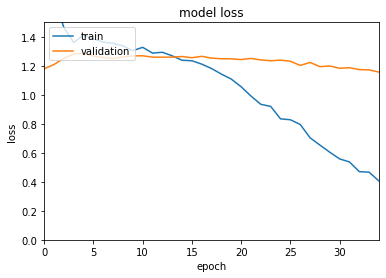

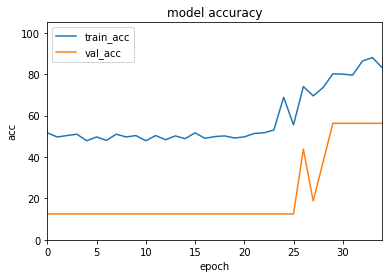

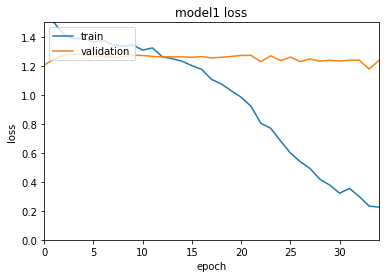

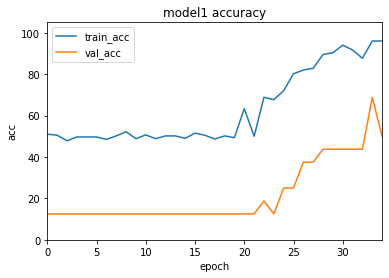

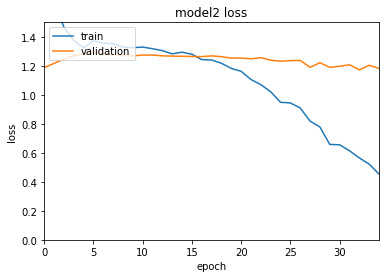

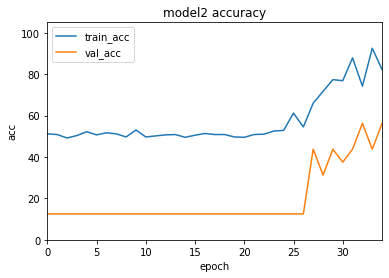

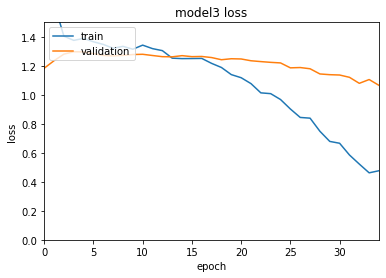

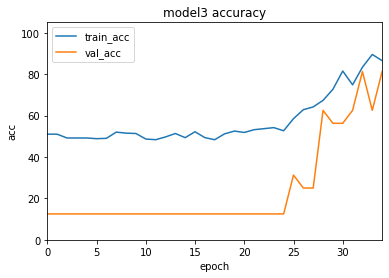

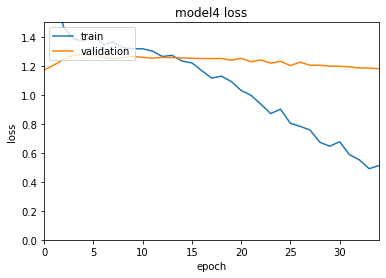

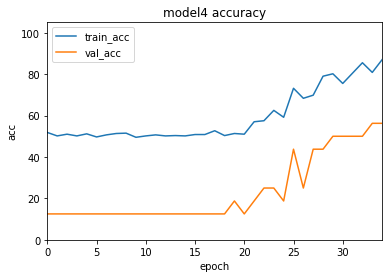

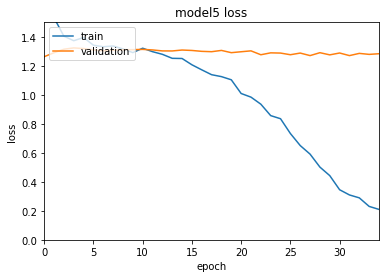

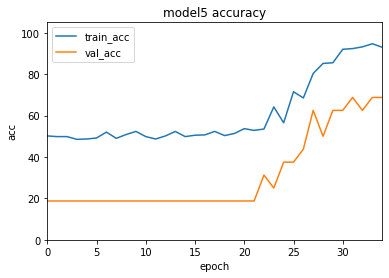

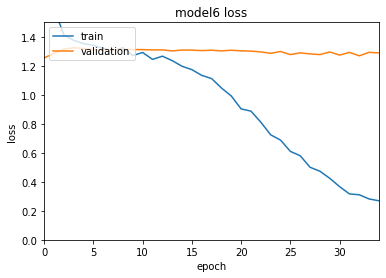

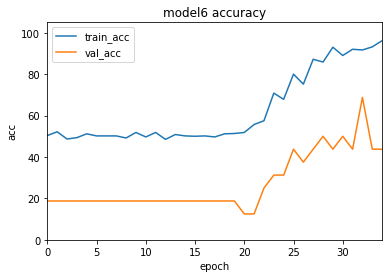

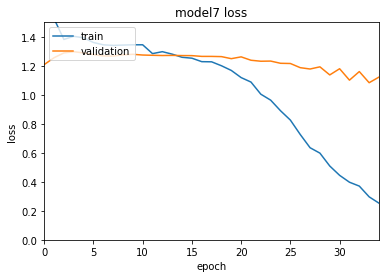

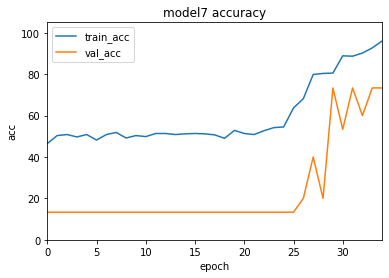

In [20]:
#Plotting loss
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss1)
plt.plot(val_loss1)
plt.title('model1 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc1)
plt.plot(val_acc1)
plt.title('model1 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss2)
plt.plot(val_loss2)
plt.title('model2 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc2)
plt.plot(val_acc2)
plt.title('model2 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss3)
plt.plot(val_loss3)
plt.title('model3 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc3)
plt.plot(val_acc3)
plt.title('model3 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss4)
plt.plot(val_loss4)
plt.title('model4 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc4)
plt.plot(val_acc4)
plt.title('model4 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss5)
plt.plot(val_loss5)
plt.title('model5 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc5)
plt.plot(val_acc5)
plt.title('model5 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss6)
plt.plot(val_loss6)
plt.title('model6 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc6)
plt.plot(val_acc6)
plt.title('model6 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss7)
plt.plot(val_loss7)
plt.title('model7 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc7)
plt.plot(val_acc7)
plt.title('model7 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

Validation Accuracy |  56.25  PPV |  [0.81818182 0.        ]  Recall |  [0.64285714 0.        ]


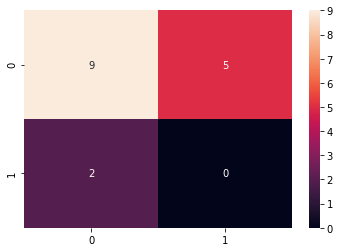

In [21]:
final_prediction = []
final_prediction_true = []

y_pred_list = []
test_loader = DataLoader(dataset=test_data, batch_size=1)
model.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_0, y_pred_list)
ppv = precision_score(testing_fold_Y_0, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_0, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_0, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_0:
    final_prediction_true.append(y)

Validation Accuracy |  50.0  PPV |  [0.8 0. ]  Recall |  [0.57142857 0.        ]


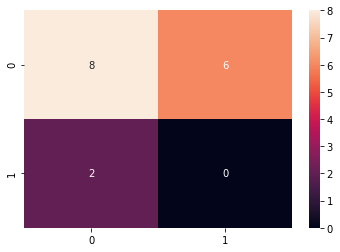

In [22]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data1, batch_size=1)
model1.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model1(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_1, y_pred_list)
ppv = precision_score(testing_fold_Y_1, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_1, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_1, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_1:
    final_prediction_true.append(y)

Validation Accuracy |  56.25  PPV |  [0.81818182 0.        ]  Recall |  [0.64285714 0.        ]


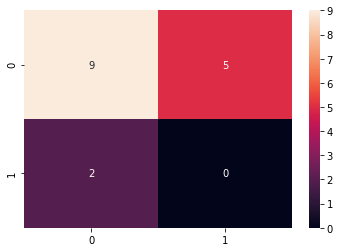

In [23]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data2, batch_size=1)
model2.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model2(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_2, y_pred_list)
ppv = precision_score(testing_fold_Y_2, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_2, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_2, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_2:
    final_prediction_true.append(y)

Validation Accuracy |  81.25  PPV |  [0.92307692 0.33333333]  Recall |  [0.85714286 0.5       ]


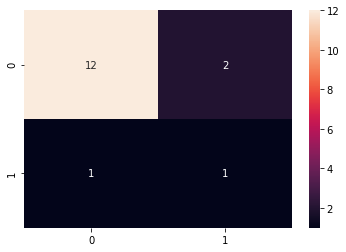

In [24]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data3, batch_size=1)
model3.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model3(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_3, y_pred_list)
ppv = precision_score(testing_fold_Y_3, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_3, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_3, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_3:
    final_prediction_true.append(y)

Validation Accuracy |  56.25  PPV |  [0.81818182 0.        ]  Recall |  [0.64285714 0.        ]


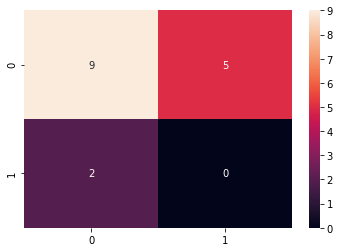

In [25]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data4, batch_size=1)
model4.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model4(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_4, y_pred_list)
ppv = precision_score(testing_fold_Y_4, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_4, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_4, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_4:
    final_prediction_true.append(y)

Validation Accuracy |  68.75  PPV |  [0.78571429 0.        ]  Recall |  [0.84615385 0.        ]


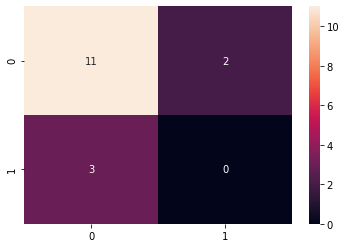

In [26]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data5, batch_size=1)
model5.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model5(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_5, y_pred_list)
ppv = precision_score(testing_fold_Y_5, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_5, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_5, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_5:
    final_prediction_true.append(y)

Validation Accuracy |  43.75  PPV |  [0.7 0. ]  Recall |  [0.53846154 0.        ]


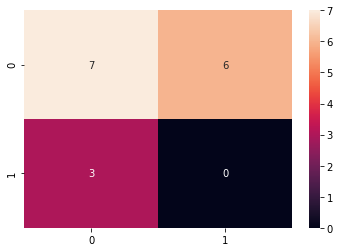

In [27]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data6, batch_size=1)
model6.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model6(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_6, y_pred_list)
ppv = precision_score(testing_fold_Y_6, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_6, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_6, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_6:
    final_prediction_true.append(y)

Validation Accuracy |  73.33333333333333  PPV |  [0.90909091 0.25      ]  Recall |  [0.76923077 0.5       ]


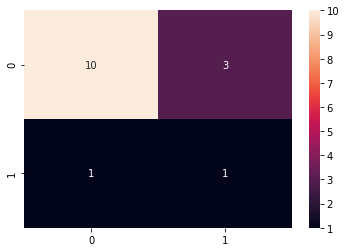

In [28]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data7, batch_size=1)
model7.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model7(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_7, y_pred_list)
ppv = precision_score(testing_fold_Y_7, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_7, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_7, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_7:
    final_prediction_true.append(y)

In [29]:
prediction_labels = []
true_labels = []

for x in range(0,len(final_prediction_true)):
    true_labels.append(final_prediction_true[x][0])
    prediction_labels.append(final_prediction[x][0][0])

prediction_labels

[1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

[[75 34]
 [16  2]]
Positive Predictive Value tp/(tp+fp):  0.05555555555555555
Accuracy Value (tp+tn)/(tp+fp+fn+tn):  0.6062992125984252
Recall Value tp/(tp+fn):  0.1111111111111111


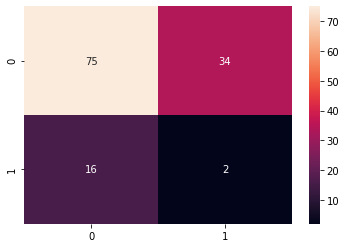

In [30]:
cf_matrix = confusion_matrix(true_labels, prediction_labels)
print(cf_matrix)
sn.heatmap(cf_matrix, annot=True)


accuracy = accuracy_score(true_labels, prediction_labels)
recall = recall_score(true_labels, prediction_labels, average=None)
prec_score = precision_score(true_labels, prediction_labels, average=None)
print('Positive Predictive Value tp/(tp+fp): ',prec_score[1]) 
print('Accuracy Value (tp+tn)/(tp+fp+fn+tn): ',accuracy) 
print('Recall Value tp/(tp+fn): ',recall[1]) 